In [1]:
!pip install pymc xarray

In [2]:
import pymc as pm
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az
import xarray as xr
import logging
import tqdm
from google.colab import files

In [3]:
#Import Data
uploaded = files.upload()


Saving calories_burned_data.csv to calories_burned_data.csv


In [4]:
#Read the data
df = pd.read_csv('calories_burned_data.csv')

In [5]:
df

,Gender,Age,Height(cm),Weight(kg),BMI,Running Time(min),Running Speed(km/h),Distance(km),Average Heart Rate,Calories Burned
0,Male,49,184,74,20.4,78,9.5,3.00,139,973
1,Female,56,182,70,23.2,98,10.2,5.23,165,494
2,Male,49,170,85,27.4,91,10.4,7.61,134,954
3,Male,21,181,59,24.0,89,13.4,14.19,144,570
4,Male,47,172,86,29.8,79,9.8,3.84,149,385
...,...,...,...,...,...,...,...,...,...,...
195,Female,54,199,51,18.5,92,10.4,3.21,155,264
196,Female,41,194,59,19.8,90,14.0,12.56,121,275
197,Female,46,160,79,23.9,78,10.3,6.53,134,910
198,Male,63,178,99,25.5,100,10.7,13.94,153,342


Exploratory Data Analysis

In [6]:
#Cek Info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Gender               200 non-null    object 
 1   Age                  200 non-null    int64  
 2   Height(cm)           200 non-null    int64  
 3   Weight(kg)           200 non-null    int64  
 4   BMI                  200 non-null    float64
 5   Running Time(min)    200 non-null    int64  
 6   Running Speed(km/h)  200 non-null    float64
 7   Distance(km)         200 non-null    float64
 8   Average Heart Rate   200 non-null    int64  
 9   Calories Burned      200 non-null    int64  
dtypes: float64(3), int64(6), object(1)
memory usage: 15.8+ KB


In [7]:
#cek Missing
df.isnull().sum()

,0
Gender,0
Age,0
Height(cm),0
Weight(kg),0
BMI,0
Running Time(min),0
Running Speed(km/h),0
Distance(km),0
Average Heart Rate,0
Calories Burned,0


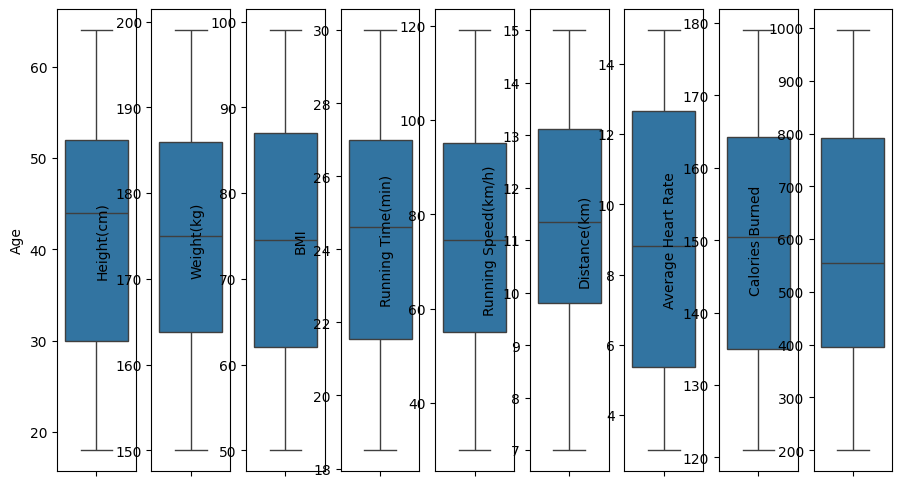

In [8]:
df2 = pd.DataFrame(df)

# Fungsi untuk mendeteksi outlier menggunakan IQR
def detect_outliers_iqr(df2):
    outliers = {}
    for column in df2.columns:
        # Check if the column contains numeric data
        if pd.api.types.is_numeric_dtype(df2[column]):
            Q1 = df2[column].quantile(0.25)
            Q3 = df2[column].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            outliers[column] = df2[(df2[column] < lower_bound) | (df2[column] > upper_bound)]
    return outliers

# Memanggil fungsi untuk mendeteksi outlier
outliers_iqr = detect_outliers_iqr(df2)

# Visualisasi outlier dengan boxplot
plt.figure(figsize=(12, 6))

# Visualisasi untuk setiap feature
for i, column in enumerate(df2.columns, 1):
    # Check if the column contains numeric data
    if pd.api.types.is_numeric_dtype(df2[column]):
        plt.subplot(1, len(df2.columns), i)
        sns.boxplot(y=df2[column])

plt.show()

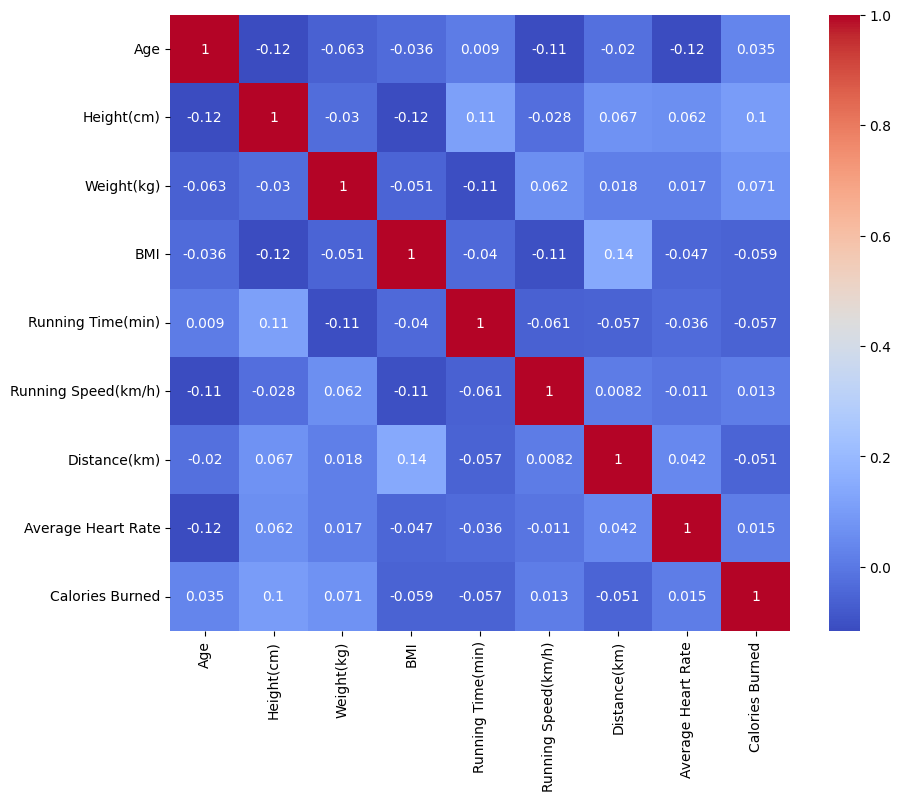

In [9]:
# Membuat heatmap korelasi
plt.figure(figsize=(10, 8))

sns.heatmap(df2.corr(numeric_only=True), annot=True, cmap='coolwarm')

plt.show()

In [10]:
features = ['Age','Height(cm)','Weight(kg)','BMI','Running Time(min)','Running Speed(km/h)','Distance(km)','Average Heart Rate']

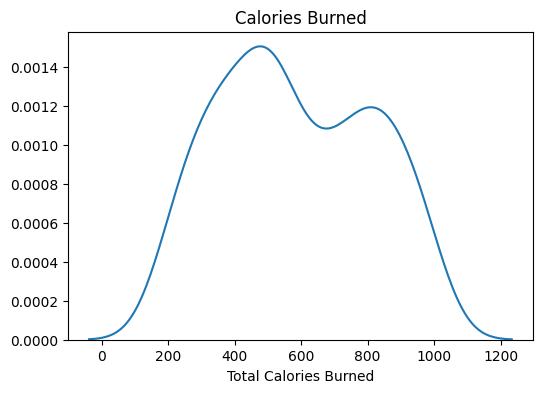

In [11]:
#Visualize the distribution of the target variable
plt.figure(figsize=(6, 4))
sns.kdeplot(df['Calories Burned'])
plt.title('Calories Burned')
plt.xlabel('Total Calories Burned')
plt.ylabel('')
plt.show()

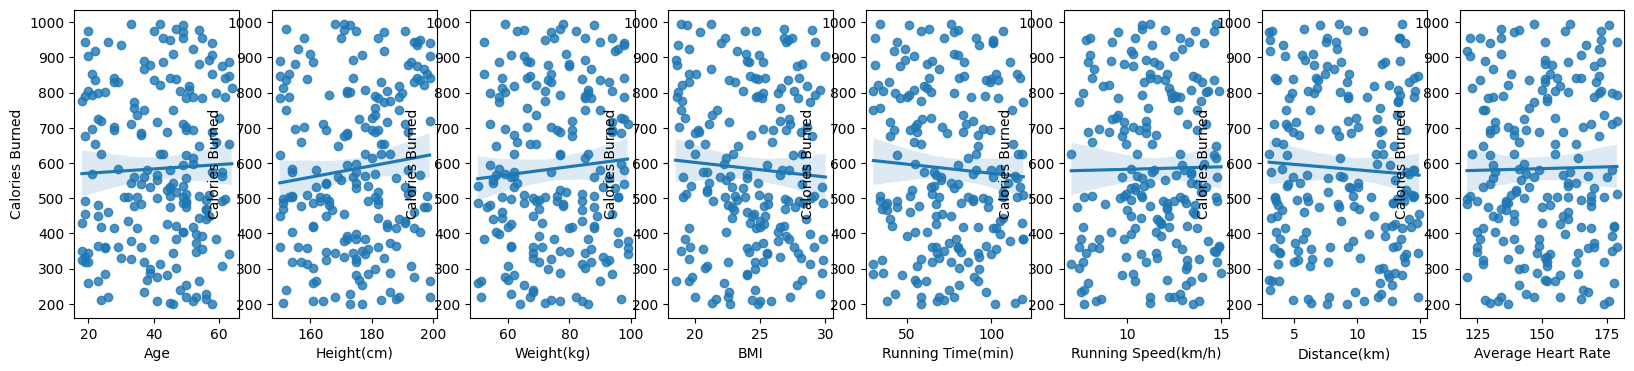

In [12]:
#Visualize the distribution of the target variable
fig,ax = plt.subplots(nrows=1,ncols=len(features),figsize=(20,4))
for idx in range(len(features)) :

    sns.regplot(df,x=features[idx],y="Calories Burned",ax=ax[idx])

Scaling


In [13]:
#Scaling to Log
df['log_Calories'] = np.log(df['Calories Burned'])
df['log_Weight(kg)'] = np.log(df['Weight(kg)'])

Text(0.5, 1.0, 'Original Scale')

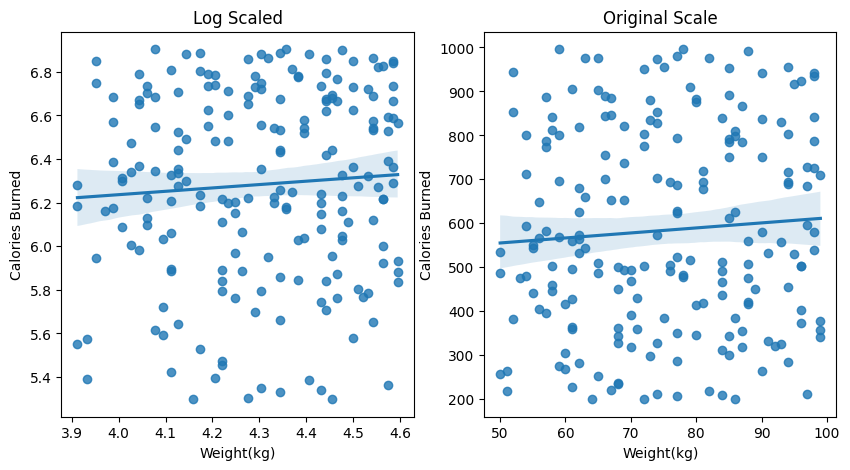

In [14]:
#Comparing Between Original and Log
fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(10,5))
sns.regplot(x=np.log(df['Weight(kg)']),y=np.log(df['Calories Burned']),ax=ax[0])
sns.regplot(x=df['Weight(kg)'],y=df['Calories Burned'],ax=ax[1])


ax[0].set_title('Log Scaled')
ax[1].set_title('Original Scale')

Likelihood

<Axes: xlabel='log_Calories', ylabel='Density'>

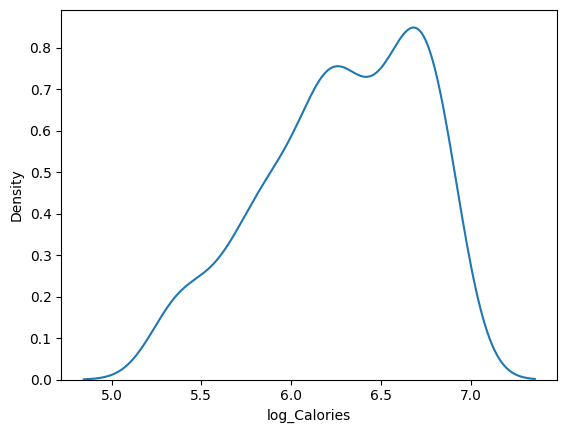

In [15]:
#Visualize Distribution Log
sns.kdeplot(data=df,x='log_Calories')

In [44]:
with pm.Model() as Calories_model :
  #Prior
  a = pm.Normal('a',1,0.2)
  b = pm.Normal('b',1,0.1)
  sigma = pm.Exponential('sigma',0.5)

  #Likelihood

  linear_model = pm.Deterministic('mu',a + b * df['log_Weight(kg)'].values)
  likelihood = pm.Normal('Calories',mu=linear_model,sigma=sigma,observed=df['log_Calories'].values)

4. Prior Predictive Checking

In [17]:
with Calories_model:
      Calories_model_prior = pm.sample_prior_predictive(samples=50)

Text(0.5, 1.0, 'Prior Prediction Plot using Original scale')

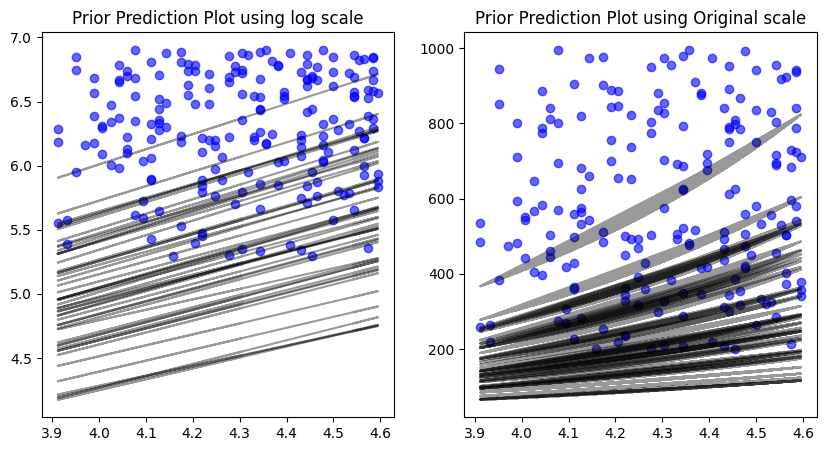

In [45]:
shape_prior_samples = Calories_model_prior.prior['a'].values.flatten().shape[0]
n_df = df.shape[0]
Calories_pred = np.zeros(( n_df , shape_prior_samples ))


for i, val in enumerate(df['log_Weight(kg)']):
    # dont forget to inverse
    Calories_pred[i] = Calories_model_prior.prior["a"] + Calories_model_prior.prior["b"]  * val

inverse_scaled_calories = np.exp(Calories_pred)

fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(10,5))
for i in range(shape_prior_samples) :
    ax[0].plot(df['log_Weight(kg)'],Calories_pred[:,i], c="k", alpha=0.4)

ax[0].scatter(df['log_Weight(kg)'],df['log_Calories'], c="blue", alpha=0.6)
ax[0].set_title('Prior Prediction Plot using log scale')



for i in range(shape_prior_samples) :
    ax[1].plot(df['log_Weight(kg)'],inverse_scaled_calories[:,i], c="k", alpha=0.4)

ax[1].scatter(df['log_Weight(kg)'],df['Calories Burned'], c="blue", alpha=0.6)
ax[1].set_title('Prior Prediction Plot using Original scale')

Fitting Model


In [19]:
RANDOM_SEED = 42

In [20]:
with Calories_model :
  Calories_model_trace = pm.sample(2000,random_seed=RANDOM_SEED)

5. Checking Model Inference Process

array([[<Axes: title={'center': 'a'}>, <Axes: title={'center': 'a'}>],
       [<Axes: title={'center': 'b'}>, <Axes: title={'center': 'b'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>]], dtype=object)

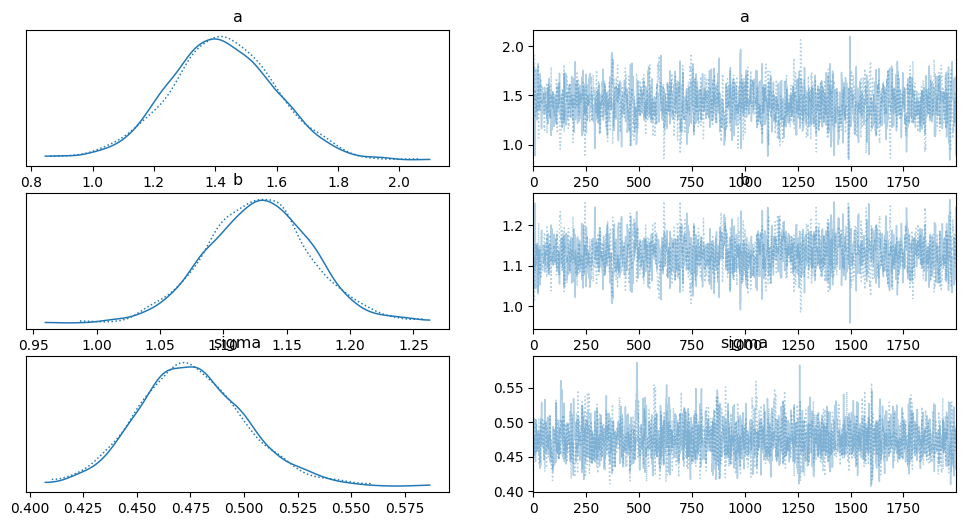

In [21]:
#Visualize
az.plot_trace(Calories_model_trace, var_names=('a','b','sigma'))

array([[<Axes: title={'center': 'a\n0'}>,
        <Axes: title={'center': 'a\n1'}>,
        <Axes: title={'center': 'b\n0'}>],
       [<Axes: title={'center': 'b\n1'}>,
        <Axes: title={'center': 'sigma\n0'}>,
        <Axes: title={'center': 'sigma\n1'}>]], dtype=object)

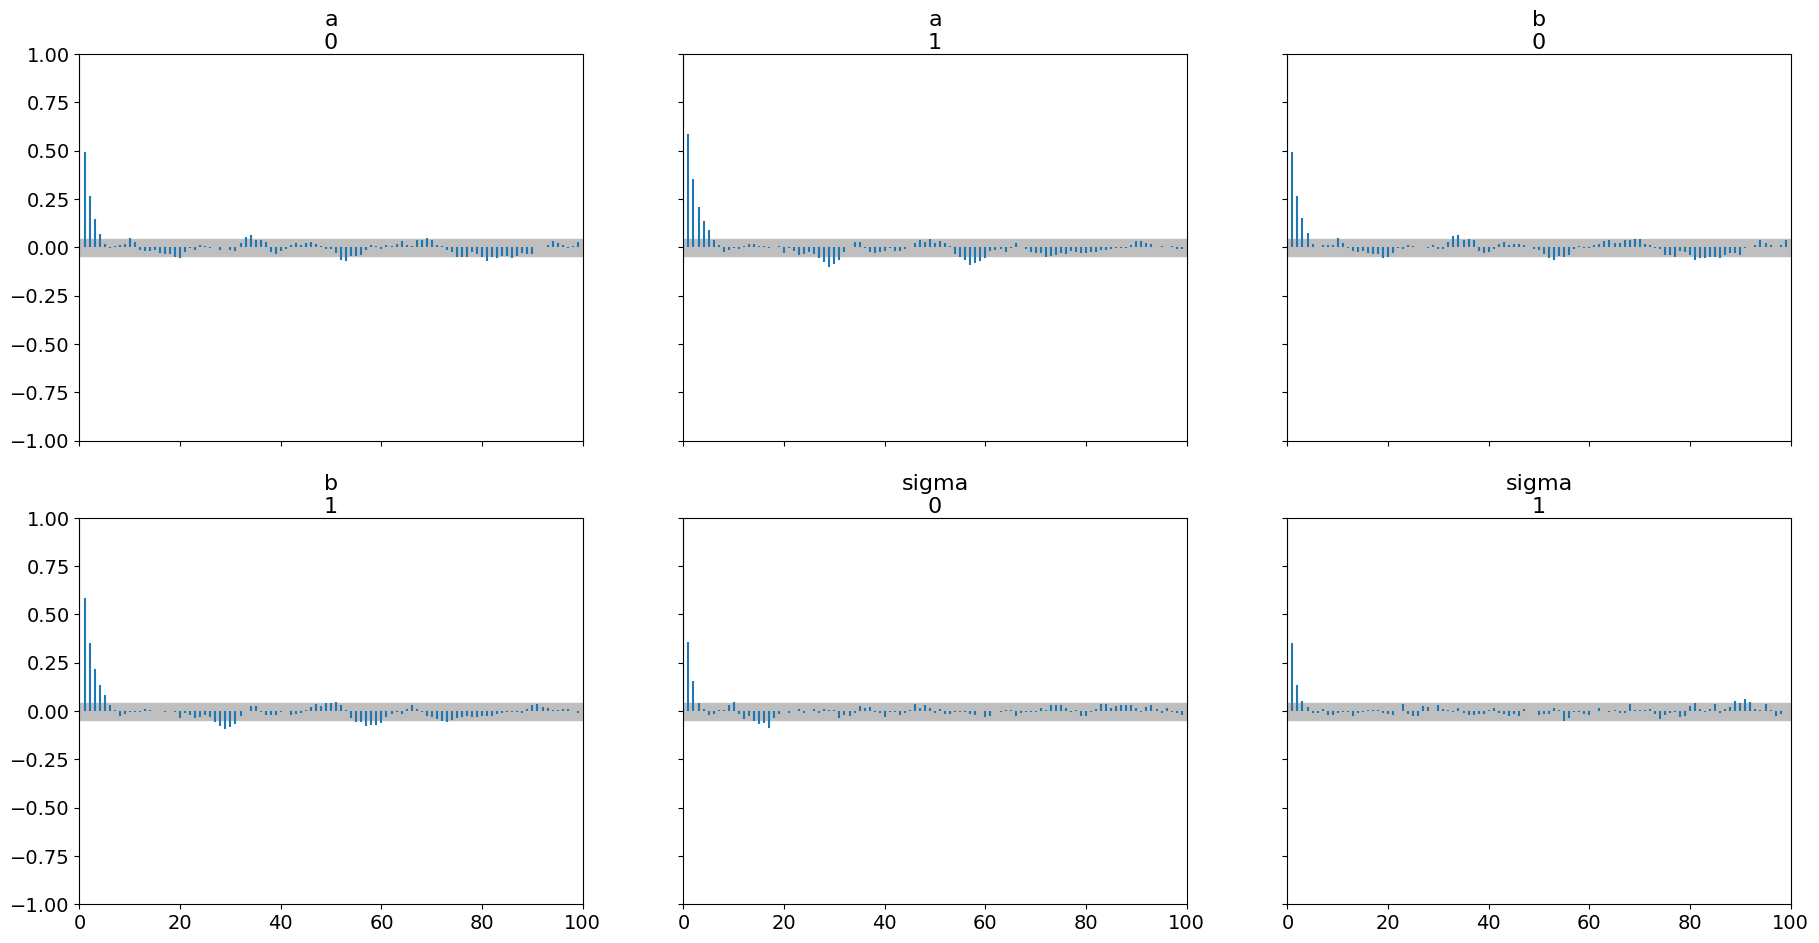

In [22]:
#Visualize Corr
az.plot_autocorr(Calories_model_trace,var_names=['a','b','sigma'])

In [23]:
#Summary
az.summary(Calories_model_trace,var_names=['a','b','sigma'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,1.418,0.176,1.105,1.769,0.005,0.004,1176.0,1439.0,1.0
b,1.128,0.041,1.047,1.204,0.001,0.001,1164.0,1531.0,1.0
sigma,0.475,0.025,0.431,0.526,0.001,0.000,1916.0,1526.0,1.0


array([<Axes: title={'center': 'a'}>, <Axes: title={'center': 'b'}>,
       <Axes: title={'center': 'sigma'}>], dtype=object)

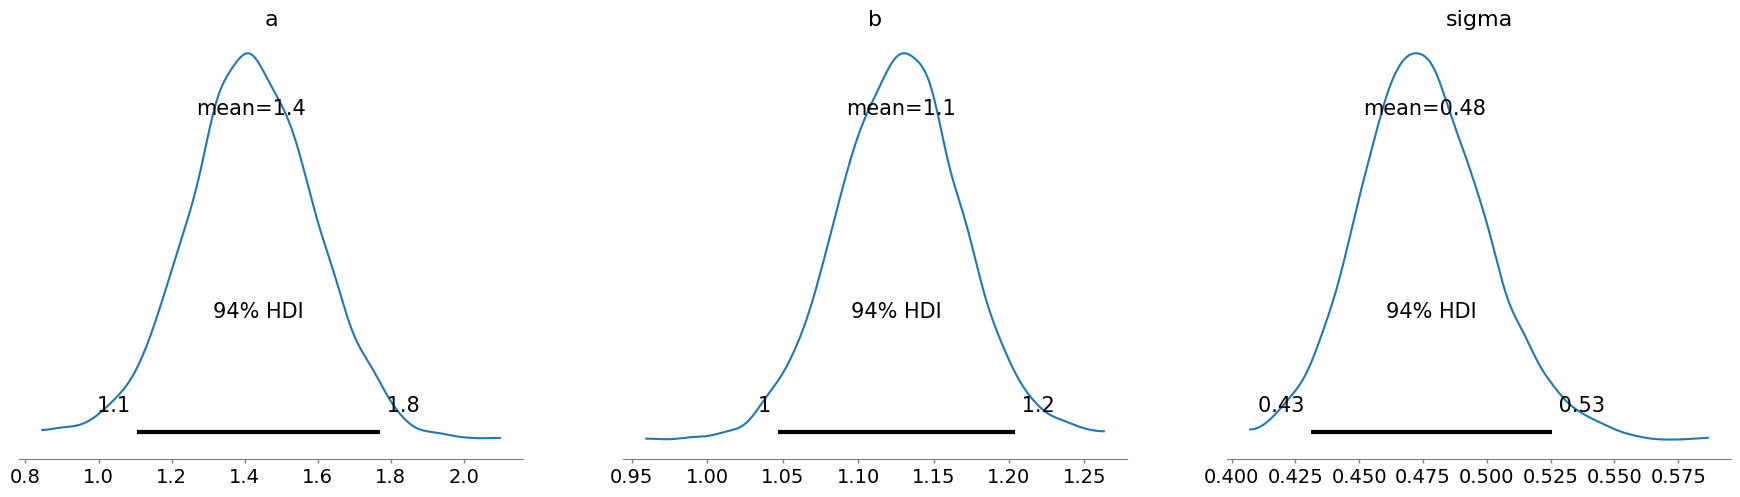

In [24]:
#Visualize plot
az.plot_posterior(Calories_model_trace,var_names=['a','b','sigma'])

Text(0.5, 1.0, 'exp from sigma posterior')

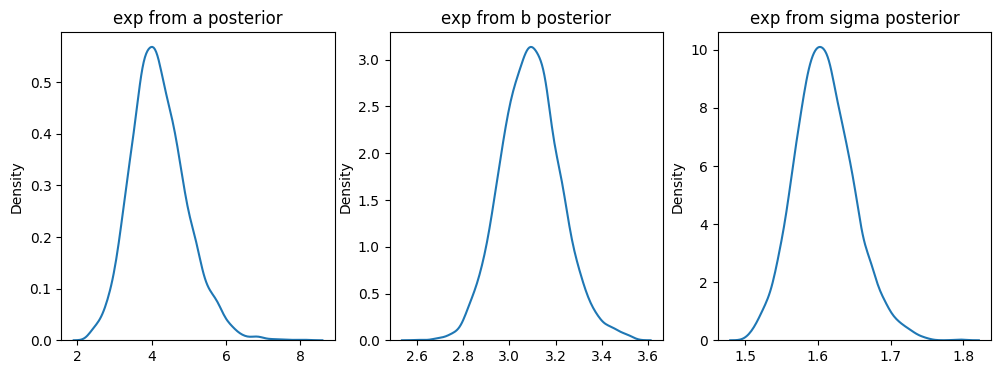

In [25]:
figure_post,ax = plt.subplots(nrows=1,ncols=3,figsize=(12,4))
exp_a = np.exp(Calories_model_trace.posterior['a'].values.flatten())
exp_b = np.exp(Calories_model_trace.posterior['b'].values.flatten())
exp_sigma = np.exp(Calories_model_trace.posterior['sigma'].values.flatten())
sns.kdeplot(exp_a,ax=ax[0])
sns.kdeplot(exp_b,ax=ax[1])
sns.kdeplot(exp_sigma,ax=ax[2])

ax[0].set_title('exp from a posterior')
ax[1].set_title('exp from b posterior')
ax[2].set_title('exp from sigma posterior')

Constructing Data Based on Model Fit (Posterior)

Fitting Model using Fake Data

In [26]:
#Generate calories
Weight = np.linspace(3, 5, 500)

#Generate Weight based on the model
intercept = 0.5
beta_cal = 1.5
sigma = np.random.normal(0, 0.5, size=Weight.shape)
Calories = intercept + beta_cal * Weight + sigma

#Create a DataFrame
fake_data_calories = pd.DataFrame({'log_Weight(kg)': Weight, 'log_Calories': Calories})

In [27]:
with pm.Model() as fake_data_model :
  #Prior
  a = pm.Normal('a',1,0.2)
  b = pm.Normal('b',1,0.1)
  sigma = pm.Exponential('sigma',0.5)

  #Likelihood

  linear_model = pm.Deterministic('mu',a + b * fake_data_calories['log_Weight(kg)'].values)
  likelihood = pm.Normal('Calories',mu=linear_model,sigma=sigma,observed=fake_data_calories['log_Calories'].values)




In [28]:
with fake_data_model :
    fake_model_trace = pm.sample(2000,random_seed=RANDOM_SEED)

In [29]:
#Summary fake model
az.summary(fake_model_trace,var_names=['a','b','sigma'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,0.753,0.116,0.530,0.968,0.003,0.002,1284.0,1547.0,1.0
b,1.429,0.029,1.375,1.482,0.001,0.001,1363.0,1547.0,1.0
sigma,0.494,0.016,0.466,0.527,0.000,0.000,1607.0,1702.0,1.0


Evaluating Model

Posterior Predictive Check

In [30]:
with Calories_model :
    Calories_sample_ppc = pm.sample_posterior_predictive(Calories_model_trace,var_names=['Calories'],
                                                       random_seed=RANDOM_SEED)


In [31]:
Calories_simulated = Calories_sample_ppc['posterior_predictive']['Calories'].values
chain,draw,n_posterior_draw = Calories_simulated.shape
Calories_simulated = Calories_simulated.reshape(chain*draw,n_posterior_draw)

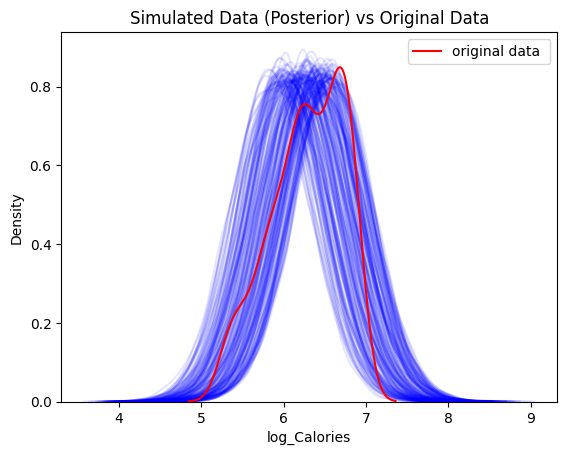

In [32]:
#Visualization
fig,ax = plt.subplots()
for idx in range(Calories_simulated.shape[1]) :
    sns.kdeplot(Calories_simulated[:,idx],alpha=0.1,color='blue')
sns.kdeplot(df['log_Calories'],label='original data ',color='red')
plt.title('Simulated Data (Posterior) vs Original Data')
plt.legend()

<Axes: xlabel='Calories'>

/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


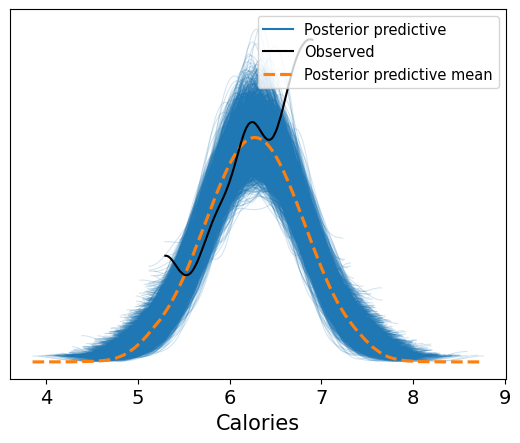

In [33]:
az.plot_ppc(Calories_sample_ppc,var_names=['Calories'],observed=True)

Cross Validation


In [71]:
df

,Gender,Age,Height(cm),Weight(kg),BMI,Running Time(min),Running Speed(km/h),Distance(km),Average Heart Rate,Calories Burned,log_Calories,log_Weight(kg),log_BMI,log_Running_Time,log_Distance
0,Male,49,184,74,20.4,78,9.5,3.00,139,973,6.880384,4.304065,3.015535,4.356709,1.098612
1,Female,56,182,70,23.2,98,10.2,5.23,165,494,6.202536,4.248495,3.144152,4.584967,1.654411
2,Male,49,170,85,27.4,91,10.4,7.61,134,954,6.860664,4.442651,3.310543,4.510860,2.029463
3,Male,21,181,59,24.0,89,13.4,14.19,144,570,6.345636,4.077537,3.178054,4.488636,2.652537
4,Male,47,172,86,29.8,79,9.8,3.84,149,385,5.953243,4.454347,3.394508,4.369448,1.345472
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,Female,54,199,51,18.5,92,10.4,3.21,155,264,5.575949,3.931826,2.917771,4.521789,1.166271
196,Female,41,194,59,19.8,90,14.0,12.56,121,275,5.616771,4.077537,2.985682,4.499810,2.530517
197,Female,46,160,79,23.9,78,10.3,6.53,134,910,6.813445,4.369448,3.173878,4.356709,1.876407
198,Male,63,178,99,25.5,100,10.7,13.94,153,342,5.834811,4.595120,3.238678,4.605170,2.634762


In [90]:
# single var model
with pm.Model() as model1 :
#
  a = pm.Normal('a',1,0.2)
  b = pm.Normal('b',1,0.1)
  sigma = pm.Exponential('sigma',0.5)

  # likelihood

  linear_model = pm.Deterministic('mu',a + b * df['log_Weight(kg)'].values)
  likelihood = pm.Normal('Calories',mu=linear_model,sigma=sigma,observed=df['log_Calories'].values)

  # sample posterior
  model1_trace = pm.sample(2000,random_seed=RANDOM_SEED)




In [91]:
#BMI','Running Time(min)'

df['log_Distance'] = np.log(df['Distance(km)'])
df['log_Running_Time'] = np.log(df['Running Time(min)'])

In [92]:
# two var model , add log Distance
with pm.Model() as model2 :
#
  a = pm.Normal('a',1,0.2)
  b_Weight_kg = pm.Normal('b_Weight(kg)',1,1)
  b_Distance = pm.Normal('b_Distance(km)',1,0.1)
  sigma = pm.Exponential('sigma',0.5)

  # likelihood

  linear_model = pm.Deterministic('mu',a + b_Weight_kg  * df['log_Weight(kg)'].values  + b_Distance  * df['log_Distance'].values)
  likelihood = pm.Normal('Calories',mu=linear_model,sigma=sigma,observed=df['log_Calories'].values)

  # sample posterior
  model2_trace = pm.sample(2000,random_seed=RANDOM_SEED)




In [93]:
# two var model , add log Running Time
with pm.Model() as model3 :
#
  a = pm.Normal('a',1,0.2)
  b_Weight_kg = pm.Normal('b_Weight(kg)',1,0.1)
  b_Distance= pm.Normal('b_Distance(km)',1,0.1)
  b_Running_Time = pm.Normal('b_Running_Time',1,0.1)
  sigma = pm.Exponential('sigma',0.5)

  # likelihood

  linear_model = pm.Deterministic('mu',a + b_Weight_kg  * df['log_Weight(kg)'].values  + b_Distance  * df['log_Distance'].values + b_Running_Time * df['log_Running_Time'].values)
  likelihood = pm.Normal('Calories',mu=linear_model,sigma=sigma,observed=df['log_Calories'].values)

  # sample posterior
  model3_trace = pm.sample(2000,random_seed=RANDOM_SEED)

In [94]:
from IPython.display import display

In [95]:
display(az.summary(model1_trace,var_names=["~mu"]))
display(az.summary(model2_trace,var_names=["~mu"]))
display(az.summary(model3_trace,var_names=["~mu"]))

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,1.418,0.176,1.105,1.769,0.005,0.004,1176.0,1439.0,1.0
b,1.128,0.041,1.047,1.204,0.001,0.001,1164.0,1531.0,1.0
sigma,0.475,0.025,0.431,0.526,0.001,0.000,1916.0,1526.0,1.0


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,1.232,0.198,0.861,1.595,0.004,0.003,2088.0,2005.0,1.0
b_Distance(km),0.365,0.062,0.240,0.474,0.001,0.001,1981.0,1863.0,1.0
b_Weight(kg),0.996,0.054,0.895,1.093,0.001,0.001,1767.0,1571.0,1.0
sigma,0.508,0.027,0.459,0.562,0.001,0.000,2215.0,2003.0,1.0


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,0.854,0.186,0.500,1.192,0.004,0.003,2834.0,2599.0,1.0
b_Distance(km),0.306,0.060,0.193,0.422,0.001,0.001,2923.0,2294.0,1.0
b_Running_Time,0.412,0.058,0.306,0.520,0.001,0.001,1998.0,2231.0,1.0
b_Weight(kg),0.708,0.062,0.589,0.820,0.001,0.001,2120.0,2094.0,1.0
sigma,0.504,0.028,0.454,0.556,0.001,0.000,2944.0,2535.0,1.0


In [96]:
with model1 :
    #ppc
    model_1_ppc = pm.sample_posterior_predictive(model1_trace,var_names=['Calories'], random_seed=RANDOM_SEED)

with model2 :
    #ppc
    model_2_ppc = pm.sample_posterior_predictive(model2_trace,var_names=['Calories'],random_seed=RANDOM_SEED)

with model3 :
    #ppc
    model_3_ppc = pm.sample_posterior_predictive(model3_trace,var_names=['Calories'],random_seed=RANDOM_SEED)


In [97]:
Calories_model1 = model_1_ppc.posterior_predictive['Calories'].values.flatten()
Calories_model2 = model_2_ppc.posterior_predictive['Calories'].values.flatten()
Calories_model3 = model_3_ppc.posterior_predictive['Calories'].values.flatten()

Text(0.5, 1.0, 'Different Model Log Calories Range of Values')

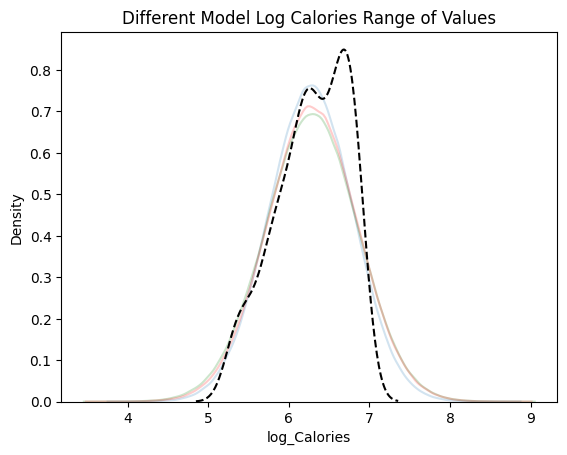

In [98]:
sns.kdeplot(Calories_model1,alpha=0.2)
sns.kdeplot(Calories_model2,color='green',alpha=0.2)
sns.kdeplot(Calories_model3,color='red',alpha=0.2)
sns.kdeplot(df['log_Calories'],color='black',linestyle='--',label='observed data')
plt.title('Different Model Log Calories Range of Values')